In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import hdbscan

C:\Users\gcmar\.conda\envs\Seg_310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
data_dir = r"C:\Users\gcmar\Dropbox (UFL)\sleap_umap_tube_test_03312023\tube_test_analysis\all_matches_videos"
df_st = pd.read_csv(data_dir+"\\"+"all_matches_videos_temporal.csv", index_col = "Unnamed: 0")

In [23]:
df_st

,trial,track_0__ear__x,track_0__ear__y,track_0__nose__x,track_0__nose__y,track_0__tail_base__x,track_0__tail_base__y,track_0__thorax__x,track_0__thorax__y,track_0__front_foot__x,...,track_1__nose__angle_to__track_1__tail_base.1,track_1__nose__angle_to__track_1__thorax.1,track_1__nose__angle_to__track_1__front_foot.1,track_1__nose__angle_to__track_1__rear_foot.1,track_1__tail_base__angle_to__track_1__thorax.1,track_1__tail_base__angle_to__track_1__front_foot.1,track_1__tail_base__angle_to__track_1__rear_foot.1,track_1__thorax__angle_to__track_1__front_foot.1,track_1__thorax__angle_to__track_1__rear_foot.1,track_1__front_foot__angle_to__track_1__rear_foot.1
0,0,15.343079,-0.284790,19.494812,-8.630615,8.258728,-3.578430,12.428986,4.009460,2.403778,...,0.013724,0.005576,0.000188,0.000129,0.006029,-0.048154,0.014540,-0.340536,-0.263997,-0.043684
1,0,15.343079,-0.284790,19.494812,-8.630615,8.258728,-3.578430,12.428986,4.009460,2.403778,...,0.013724,0.005576,0.000188,0.000129,0.006029,-0.048154,0.014540,-0.340536,-0.263997,-0.043684
2,0,16.796326,0.783203,20.389587,3.893799,15.887604,-4.247681,31.701569,3.602844,152.034058,...,0.001756,0.008925,0.012282,0.000307,0.004617,0.087241,-0.010665,0.581969,0.240995,-0.010612
3,0,35.122253,-0.153015,23.915771,8.233093,20.230591,-4.381897,35.992401,3.580688,1.055603,...,-0.004287,0.008074,0.004522,0.004797,0.004266,-0.051620,0.006238,-0.300118,-0.187733,0.023827
4,0,32.512878,3.329956,31.811646,0.409119,23.646179,-7.895142,27.867889,0.134888,7.600586,...,0.001464,0.008768,0.004665,-0.003940,-0.003538,-0.030822,0.006136,-0.223517,-0.012746,0.016018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404,35,-14.604284,17.750655,-72.032699,0.750879,0.000000,0.000000,-10.028162,8.591766,0.492966,...,-0.011448,-0.005196,-0.025236,-0.009075,-0.003268,-0.023990,-0.011042,-0.139427,0.182642,-0.000933
13405,35,0.000000,0.000000,91.910399,-7.815040,0.000000,0.000000,9.803934,7.155915,0.492966,...,0.023272,0.004755,-0.001716,0.007548,0.007375,0.003907,0.008848,-0.155770,-0.200657,0.023040
13406,35,0.000000,0.000000,91.910399,-7.815040,0.000000,0.000000,4.131592,8.256470,3.509583,...,0.025316,0.000498,-0.011090,-0.007570,-0.004431,-0.003802,0.042899,-0.112081,-0.078054,0.002883
13407,35,0.000000,0.000000,91.910399,-7.815040,0.000000,0.000000,0.045593,0.011780,0.071747,...,0.034319,0.000009,0.000020,-0.000050,0.000060,0.000174,-0.000340,0.000416,-0.000477,-0.000266


In [4]:
# apply min max normalizatrion to the data before PCA
def min_max_norm(col):
    return (col - col.min()) / (col.max() - col.min())

# Apply the function to each column
df_st_norm = df_st.drop('trial', axis=1).apply(min_max_norm)
df_st_norm['trial'] = df_st['trial']

In [5]:
df_st_norm

,track_0__ear__x,track_0__ear__y,track_0__nose__x,track_0__nose__y,track_0__tail_base__x,track_0__tail_base__y,track_0__thorax__x,track_0__thorax__y,track_0__front_foot__x,track_0__front_foot__y,...,track_1__nose__angle_to__track_1__thorax.1,track_1__nose__angle_to__track_1__front_foot.1,track_1__nose__angle_to__track_1__rear_foot.1,track_1__tail_base__angle_to__track_1__thorax.1,track_1__tail_base__angle_to__track_1__front_foot.1,track_1__tail_base__angle_to__track_1__rear_foot.1,track_1__thorax__angle_to__track_1__front_foot.1,track_1__thorax__angle_to__track_1__rear_foot.1,track_1__front_foot__angle_to__track_1__rear_foot.1,trial
0,0.515401,0.486445,0.493898,0.489632,0.463619,0.592571,0.464936,0.574018,0.451719,0.594025,...,0.500452,0.494041,0.500000,0.500481,0.487757,0.501128,0.472896,0.423924,0.496541,0
1,0.515401,0.486445,0.493898,0.489632,0.463619,0.592571,0.464936,0.574018,0.451719,0.594025,...,0.500452,0.494041,0.500000,0.500481,0.487757,0.501128,0.472896,0.423924,0.496541,0
2,0.516000,0.493610,0.494283,0.542712,0.465934,0.589161,0.471849,0.569021,0.512559,0.578255,...,0.500719,0.496170,0.500014,0.500369,0.513007,0.499122,0.546314,0.545366,0.499174,0
3,0.523547,0.487329,0.495801,0.561103,0.467252,0.588477,0.473388,0.568749,0.451171,0.573177,...,0.500651,0.494804,0.500372,0.500341,0.487110,0.500468,0.476113,0.442265,0.501915,0
4,0.522473,0.510696,0.499200,0.527944,0.468289,0.570575,0.470474,0.526402,0.453832,0.593326,...,0.500706,0.494829,0.499676,0.499720,0.490989,0.500460,0.482209,0.484346,0.501293,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13404,0.503068,0.607446,0.454501,0.529392,0.461113,0.610805,0.456880,0.630332,0.450943,0.574110,...,0.499595,0.489565,0.499268,0.499741,0.492263,0.499092,0.488902,0.531334,0.499944,35
13405,0.509083,0.488355,0.525069,0.493089,0.461113,0.610805,0.463994,0.612686,0.450943,0.574110,...,0.500387,0.493706,0.500591,0.500588,0.497466,0.500675,0.487601,0.439157,0.501852,35
13406,0.509083,0.488355,0.525069,0.493089,0.461113,0.610805,0.461959,0.626211,0.452169,0.593362,...,0.500048,0.492055,0.499388,0.499648,0.496028,0.503385,0.491078,0.468641,0.500248,35
13407,0.509083,0.488355,0.525069,0.493089,0.461113,0.610805,0.460494,0.524889,0.450771,0.572889,...,0.500009,0.494011,0.499986,0.500006,0.496770,0.499944,0.500031,0.487297,0.499997,35


# Apply PCA

In [6]:
# Create a PCA object
pca = PCA(n_components=2)
# Fit the data to the PCA model
pca.fit(df_st_norm.drop('trial',axis=1))
# Transform the data into the new coordinate system
df_pca = pd.DataFrame(pca.transform(df_st_norm.drop('trial',axis=1)))
df_pca['trial'] = df_st['trial']

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.05972927 0.04882862]


In [7]:
# Get the loadings of each feature on each principal component
loadings = pd.DataFrame(pca.components_, columns=df_st_norm.drop('trial',axis=1).columns)

# Print the loadings sorted by the absolute value (i.e., influence) of each column on the first principal component
print(loadings.iloc[0].abs().sort_values(ascending=False))

track_1__ear__angle_to__track_1__thorax          0.743458
track_1__ear__angle_to__track_1__front_foot      0.359541
track_1__ear__angle_to__track_1__front_foot.1    0.353871
track_1__thorax__angle_to__track_1__rear_foot    0.216003
track_1__nose__angle_to__track_1__rear_foot      0.170403
                                                   ...   
track_0__ear__dist_to__track_0__rear_foot        0.000433
track_0__tail_base__angle_to__track_1__ear       0.000397
track_0__front_foot__angle_to__track_1__nose     0.000217
track_0__nose__angle_to__track_1__ear            0.000174
track_0__nose__angle_to__track_0__thorax         0.000083
Name: 0, Length: 222, dtype: float64


It appears that the variance of the data is not well described by the first two principal components.

In [8]:
df_pca

,0,1,trial
0,0.275045,-0.288605,0
1,0.275045,-0.288605,0
2,-0.236921,-0.171636,0
3,-0.175130,0.023981,0
4,-0.037420,-0.164887,0
...,...,...,...
13404,0.018742,0.120026,35
13405,-0.020199,-0.183465,35
13406,-0.070402,-0.409730,35
13407,-0.009554,-0.032956,35


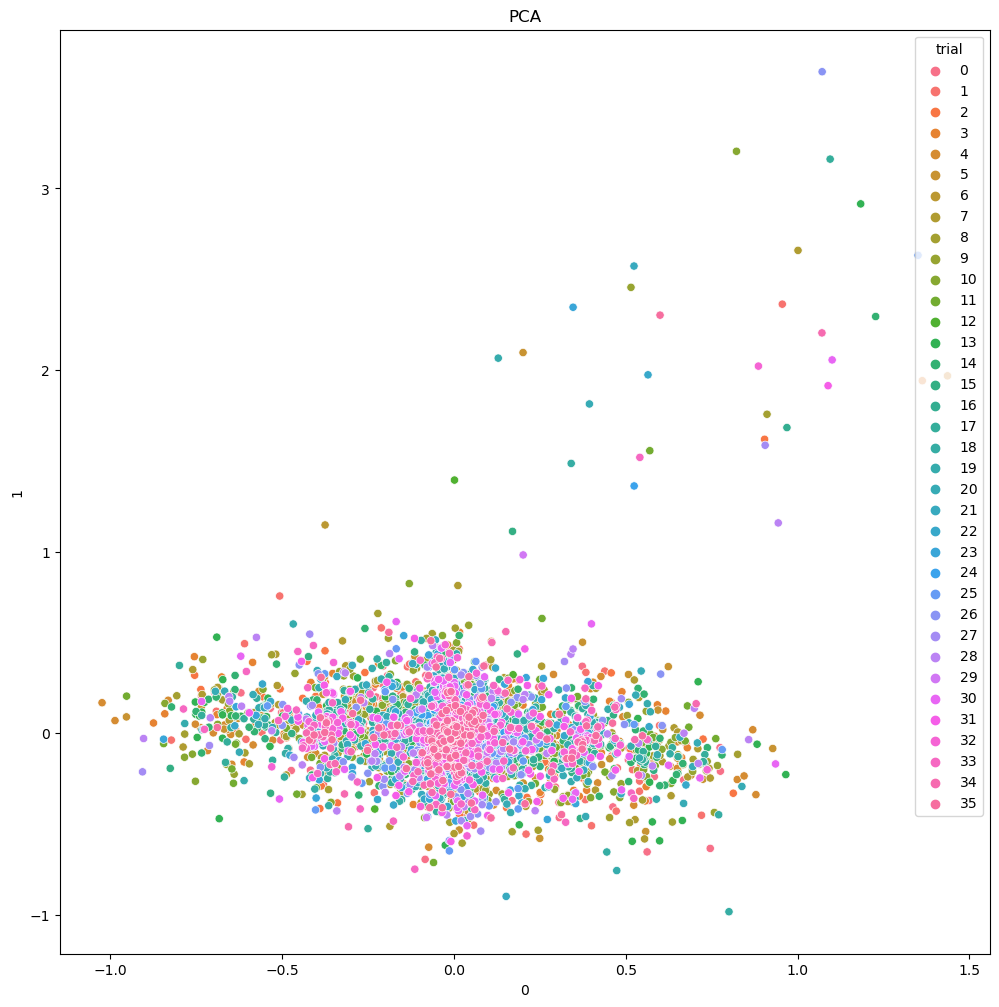

In [9]:
# create color palette unique for each trial
custom_palette = sns.color_palette("husl", 36)

plt.figure(figsize=(12, 12))
# Create a scatterplot
scatter_plot = sns.scatterplot(data=df_pca ,
                x=0, 
                y=1, 
                hue=df_pca['trial'],
                palette=custom_palette,
                )
plt.title('PCA')

# Show the plot
plt.show()

I color them by trial for no real reason.

# Apply UMAP

In [10]:
# remove trial column
X = df_st_norm.drop('trial', axis=1)

# apply UMAP
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='euclidean').fit_transform(X)

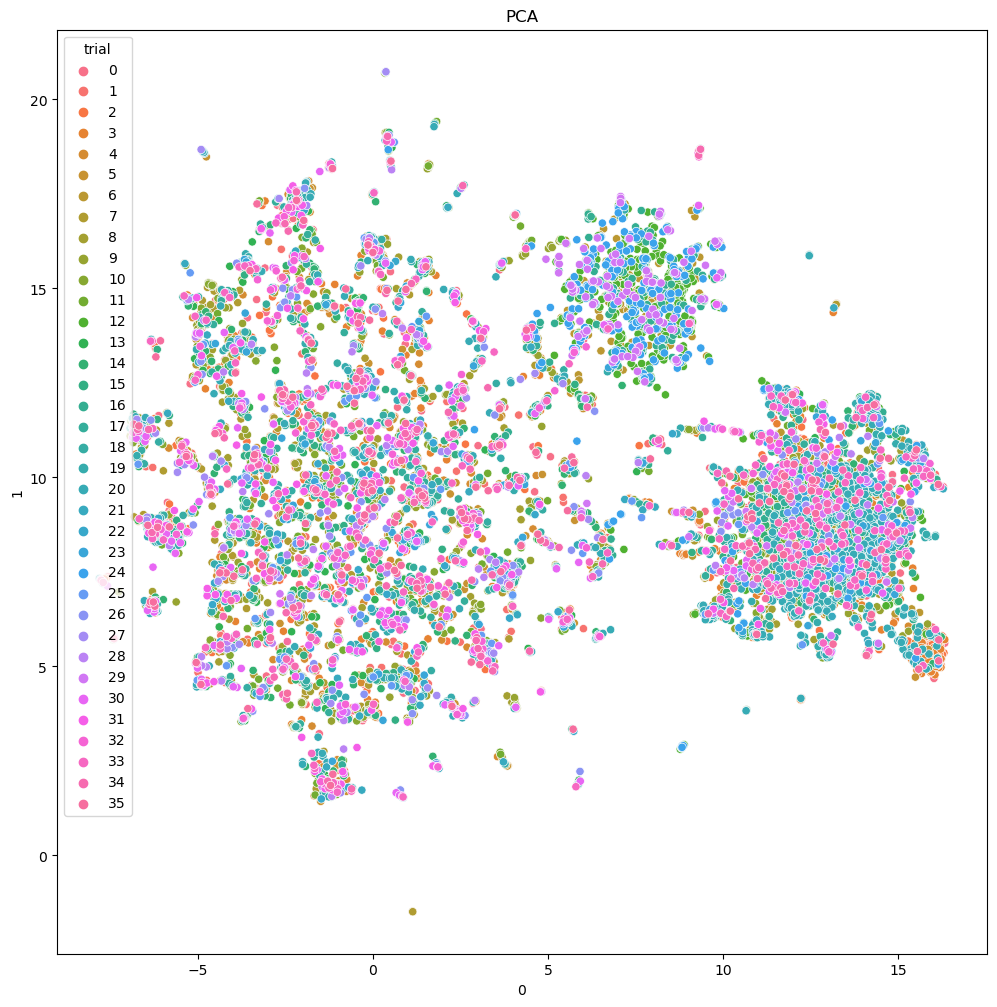

In [11]:
# add t odataframe and plot
df_umap = pd.DataFrame(embedding)
df_umap['trial'] = df_st['trial']

# create color palette unique for each trial
custom_palette = sns.color_palette("husl", 36)

plt.figure(figsize=(12, 12))
# Create a scatterplot
scatter_plot = sns.scatterplot(data=df_umap ,
                x=0, 
                y=1, 
                hue=df_pca['trial'],
                palette=custom_palette,
                )
plt.title('UMAP')

# Show the plot
plt.show()

Not a lot of structure here so it might be good to look at reducing noise by removing features and/or smoothing the temporal data
* Use only temporal data?
* smooth temporal data?
* feature selection - correlation-based feature selection (CFS)correlation-based feature selection (CFS)
* identify most informative features based on clustering output on all features

# HDBSCAN

In [28]:
# remove trial column
X = df_umap.drop('trial', axis=1)

# Perform clustering using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(X)

In [29]:
# add cluster classes to the respective frame
df_st_norm['cluster'] = cluster_labels

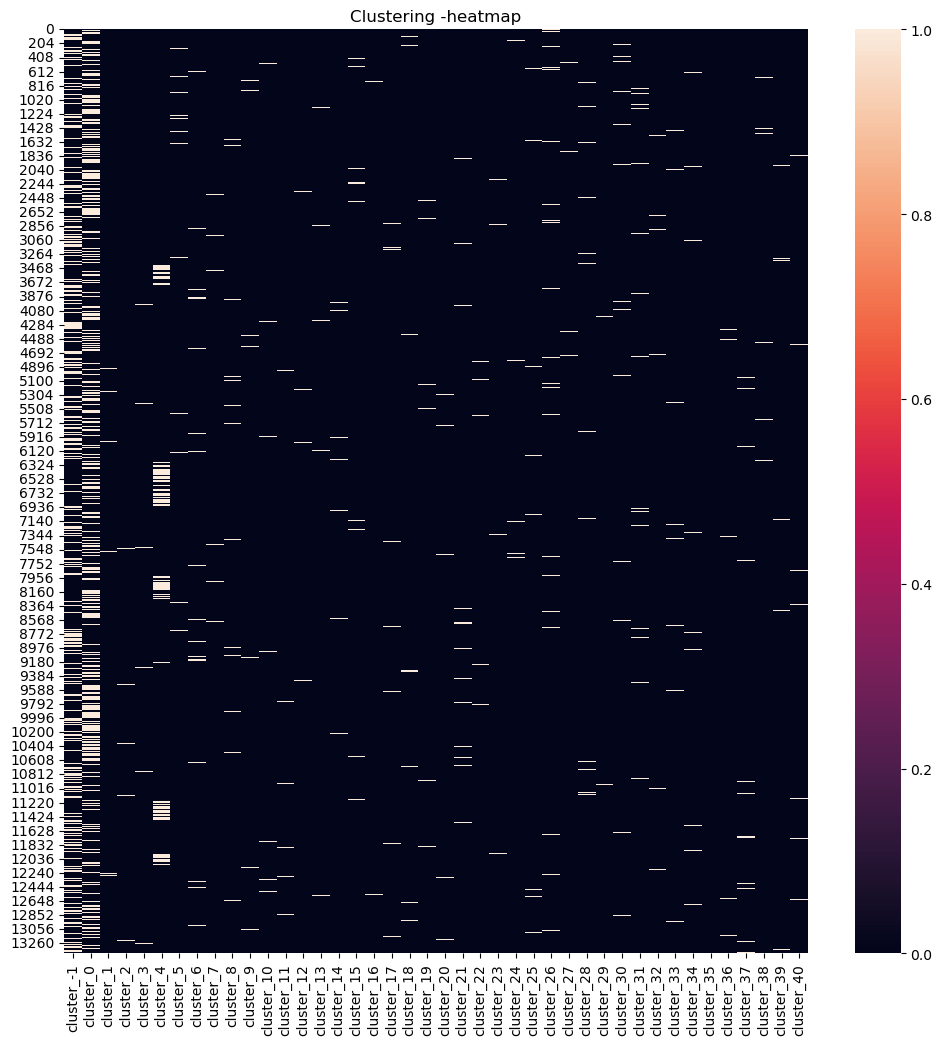

C:\Users\gcmar\AppData\Local\Temp\ipykernel_20200\525112347.py:13: UserWarning: 
The palette list has fewer values (36) than needed (42) and will cycle, which may produce an uninterpretable plot.
  scatter_plot = sns.scatterplot(data=df_umap ,


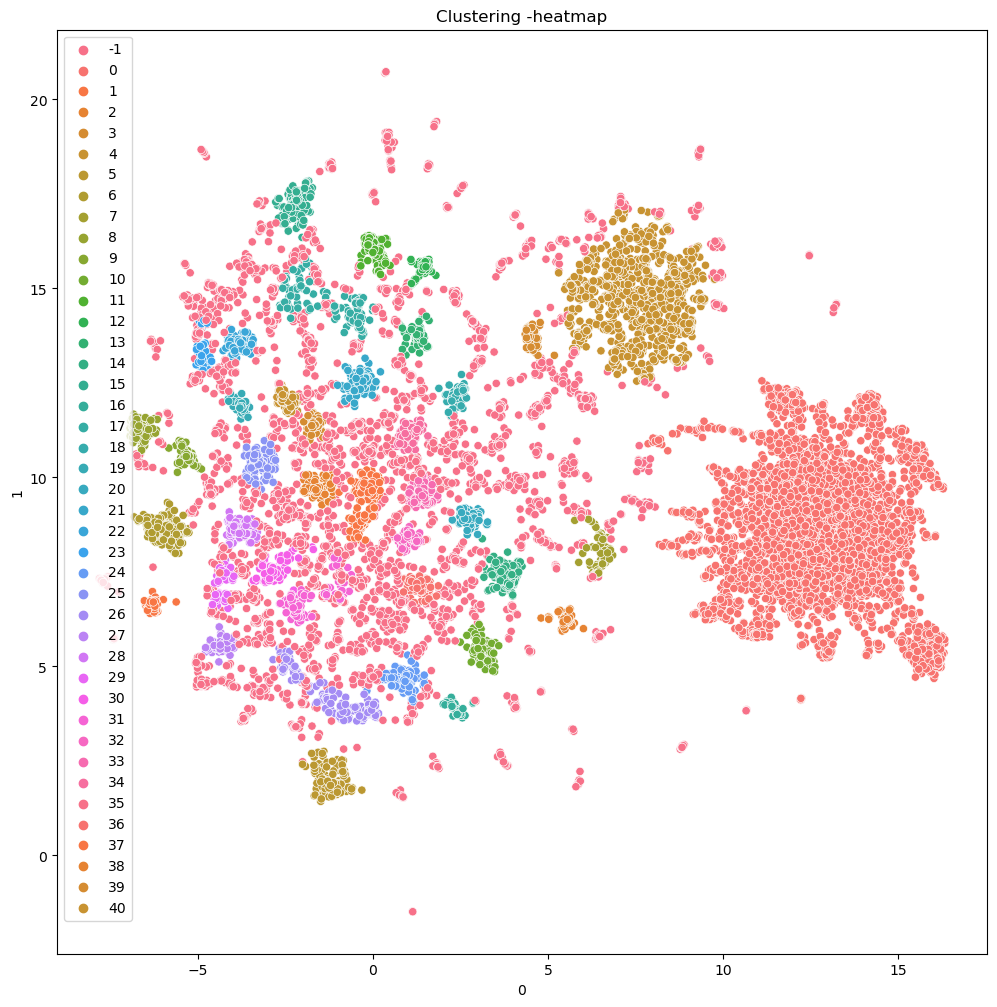

In [34]:
# onehot encode clusters
df_clust = pd.DataFrame(cluster_labels)
df_clust.columns = ["cluster"]
df_clust_onehot = pd.get_dummies(df_clust, columns=['cluster'])

# plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_clust_onehot)
plt.title('Clustering -heatmap')
plt.show()

# scatter plot repeat
plt.figure(figsize=(12, 12))
scatter_plot = sns.scatterplot(data=df_umap ,
                x=0, 
                y=1, 
                hue=cluster_labels,
                palette=custom_palette,
                )
plt.title('Clustering -heatmap')
plt.show()


I deally you would wnat to see little vertical lines showing how the behaviours last a few frames at a time, might get this with some noise reduction.

It is also well within the realm of possibility that the behaviours presented are so similar that the noise in the data outweighs the differences in behaviour.